# Baseline

## Install required packages.

In [37]:
import os
import torch
os.environ['TORCH'] = torch.__version__
os.environ['PYTHONWARNINGS'] = "ignore"
print(torch.__version__)
!pip install torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install git+https://github.com/pyg-team/pytorch_geometric.git

2.6.0+cu124
Looking in links: https://data.pyg.org/whl/torch-2.6.0+cu124.html
Looking in links: https://data.pyg.org/whl/torch-2.6.0+cu124.html
  Cloning https://github.com/pyg-team/pytorch_geometric.git to /tmp/pip-req-build-ae7pe2rn
  Running command git clone --filter=blob:none --quiet https://github.com/pyg-team/pytorch_geometric.git /tmp/pip-req-build-ae7pe2rn
  Resolved https://github.com/pyg-team/pytorch_geometric.git to commit 4410298df8de8ca9f13ba4ee12e6a30ec82c42d1
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [38]:
!unzip data.zip -d .

Archive:  data.zip
replace ./data/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

## Set up

In [53]:
import os
from pathlib import Path
import pandas as pd
import pickle
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.utils import from_networkx
from torch.nn.utils.rnn import pad_sequence


from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score

PATH = './data/labeled'
JSON_PATH = os.path.join(PATH, 'txn')
label_names = ["Mint", "Leak", "Limit"]

In [54]:
def tune_thresholds(y_true, y_pred_prob, metric='f1'):
    y_true = np.asarray(y_true)
    y_pred_prob = np.asarray(y_pred_prob)

    best_thresholds = []
    best_scores = []

    for i in range(y_true.shape[1]):
        label_true = y_true[:, i]
        label_probs = y_pred_prob[:, i]

        thresholds = np.linspace(0.0, 1.0, 101)
        scores = []

        for t in thresholds:
            label_pred = (label_probs >= t).astype(int)
            if np.sum(label_pred) == 0:
                score = 0
            else:
                if metric == 'f1':
                    score = f1_score(label_true, label_pred, zero_division=0)
                elif metric == 'precision':
                    score = precision_score(label_true, label_pred, zero_division=0)
                elif metric == 'recall':
                    score = recall_score(label_true, label_pred, zero_division=0)
                else:
                    raise ValueError("Unsupported metric: choose 'f1', 'precision', or 'recall'")
            scores.append(score)

        best_t = thresholds[np.argmax(scores)]
        best_score = np.max(scores)

        best_thresholds.append(best_t)
        best_scores.append(best_score)

        print(f"Label {i}: Best threshold = {best_t:.2f}, Best {metric} = {best_score:.4f}")

    return best_thresholds, best_scores

In [55]:
def evaluate_multilabel_classification(y_true, y_pred, label_names=None, threshold=0.5, average_types=["micro", "macro", "weighted"]):
    """
    Evaluate a multi-label classification model with multiple metrics.

    Parameters:
        y_true (ndarray): shape (n_samples, n_classes), true binary labels
        y_pred (ndarray): shape (n_samples, n_classes), predicted probabilities or logits
        label_names (list): class/label names, optional
        threshold (float): threshold to binarize y_pred if probabilities
        average_types (list): which averaging types to compute

    Returns:
        report_dict (dict): summary with precision/recall/F1 for each average type and per-class
        report_df (DataFrame): detailed classification report
    """
    # Binarize predictions
    y_pred_bin = (y_pred >= threshold).astype(int)

    report_dict = {}

    # Overall metrics by average type
    for avg in average_types:
        report_dict[f"{avg}_precision"] = precision_score(y_true, y_pred_bin, average=avg, zero_division=0)
        report_dict[f"{avg}_recall"] = recall_score(y_true, y_pred_bin, average=avg, zero_division=0)
        report_dict[f"{avg}_f1"] = f1_score(y_true, y_pred_bin, average=avg, zero_division=0)

    # Exact match ratio
    report_dict["subset_accuracy"] = accuracy_score(y_true, y_pred_bin)

    # Per-label report
    cls_report = classification_report(
        y_true, y_pred_bin, target_names=label_names, output_dict=True, zero_division=0
    )
    report_df = pd.DataFrame(cls_report).transpose()

    return report_dict, report_df


## Step 1: Align by Contract Address

In [56]:
# Load ground truth
ground = pd.read_csv(os.path.join(PATH, "groundtruth.csv"))
ground['Address'] = ground['Address'].str.lower()

# Load features (ensure index is lowercase)
def load_feature(file):
    df = pd.read_csv(file, index_col=0)
    df.index = df.index.str.lower()
    return df

bytecode = load_feature(os.path.join(PATH,"bytecode_feature.csv"))
txn_stats = load_feature(os.path.join(PATH,"transaction_feature.csv"))
txn_graph = load_feature(os.path.join(PATH,"txn_graph_features.csv"))
cfg_graph = load_feature(os.path.join(PATH,"cfg_graph_features.csv"))

txn_graph = txn_graph.rename(columns={
    "num_nodes": "txn_num_nodes",
    "num_edges": "txn_num_edges",
    "avg_degree": "txn_avg_degree",
    "density": "txn_density",
    "connected_components": "txn_connected_components",
    "avg_clustering": "txn_avg_clustering"
})

cfg_graph = cfg_graph.rename(columns={
    "num_nodes": "cfg_num_nodes",
    "num_edges": "cfg_num_edges",
    "avg_degree": "cfg_avg_degree",
    "density": "cfg_density",
    "connected_components": "cfg_connected_components",
    "avg_clustering": "cfg_avg_clustering"
})
# Reindex all feature sets to include every contract in groundtruth
addresses = ground["Address"]

bytecode = bytecode.reindex(addresses)
txn_stats = txn_stats.reindex(addresses)
txn_graph = txn_graph.reindex(addresses)
cfg_graph = cfg_graph.reindex(addresses)

# Join all with axis=1
tabular = pd.concat([bytecode, txn_stats, txn_graph, cfg_graph], axis=1)

# Fill missing values (you can customize this part)
tabular = tabular.fillna(0)

# Labels
y = ground[["Mint", "Leak", "Limit"]].values
X_tabular = tabular.values


## Step 2: Train Individual Models

### A. Tabular Classifier (MLP/XGB)

In [57]:
from xgboost import XGBClassifier
from sklearn.multioutput import MultiOutputClassifier

clf = MultiOutputClassifier(XGBClassifier())
clf.fit(X_tabular, y)

MultiOutputClassifier(estimator=XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric=None,
                                              feature_types=None,
                                              feature_weights=None, gamma=None,
                                              grow_policy=None,
                                              importance_type=None,
                                              interaction_constraints=None,
                                              learning_rate=None, max_bin=None,
                                              max_cat_threshold=None,
                                              max_cat_to_onehot=None,
                                              max_delta_step=None,
                                              max_depth=None, max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=None, n_jobs=None,
                                              num_parallel_tree=None, ...))

In [58]:
clf.score(X_tabular, y)

np.float64(0.9855072463768116)

In [59]:
y_pred_proba = clf.predict_proba(X_tabular)
y_pred_proba = np.column_stack([proba[:, 1] for proba in y_pred_proba])

In [60]:
evaluate_multilabel_classification(y, y_pred_proba, label_names=label_names)

({'micro_precision': 1.0,
  'micro_recall': 0.9830508474576272,
  'micro_f1': 0.9914529914529915,
  'macro_precision': 1.0,
  'macro_recall': 0.9833333333333334,
  'macro_f1': 0.9914529914529915,
  'weighted_precision': 1.0,
  'weighted_recall': 0.9830508474576272,
  'weighted_f1': 0.9913081269013473,
  'subset_accuracy': 0.9855072463768116},
               precision    recall  f1-score  support
 Mint           1.000000  0.950000  0.974359     20.0
 Leak           1.000000  1.000000  1.000000      9.0
 Limit          1.000000  1.000000  1.000000     30.0
 micro avg      1.000000  0.983051  0.991453     59.0
 macro avg      1.000000  0.983333  0.991453     59.0
 weighted avg   1.000000  0.983051  0.991308     59.0
 samples avg    0.608696  0.601449  0.603865     59.0)

### B. Time-Series Model

In [61]:
def load_sequence(file_path):
    with open(file_path) as f:
        j = json.load(f)

    txns = j.get('transaction', [])
    seq = []

    for tx in txns:
        try:
            time = int(tx.get('timeStamp', 0))
            value = int(tx.get('value', 0))
            gas_used = int(tx.get('gasUsed', 0))
            seq.append((time, value, gas_used))
        except:
            continue

    # Sort by time
    seq.sort(key=lambda x: x[0])

    # Convert to deltas
    if seq:
        t0 = seq[0][0]
        seq = [(t - t0, value, gas) for (t, value, gas) in seq]

    return seq


In [62]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, 3)  # for 3 labels
    def forward(self, x):
        _, (h, _) = self.lstm(x)
        return self.out(h[-1])


#### Load

In [63]:
# Collect all sequences from JSONs
all_sequences = []
addresses = []

for json_path in list(Path(JSON_PATH).glob('*.json')):  # list of .json files
    seq = load_sequence(json_path)
    if len(seq) == 0:
        continue
    all_sequences.append(torch.tensor(seq, dtype=torch.float32))
    address = json_path.stem
    addresses.append(address)


#### Pad Sequences to Uniform Length

In [64]:
# Pad to max length
padded_seqs = pad_sequence(all_sequences, batch_first=True)  # [B, T, 3]

#### Normalize Time/Value/Gas Columns

In [65]:
# Flatten for fitting
flat = torch.cat(all_sequences).numpy()

# Standardize
scaler = StandardScaler()
scaler.fit(flat)

# Apply to all sequences
normalized_seqs = [torch.tensor(scaler.transform(seq), dtype=torch.float32) for seq in all_sequences]
padded_normalized = pad_sequence(normalized_seqs, batch_first=True)

#### Train

In [66]:
# Inputs
X_tensor = padded_normalized  # shape [batch_size, seq_len, 3]

# Align y_tensor with the addresses for which sequences were loaded
y_tensor = torch.tensor(ground.set_index('Address').loc[addresses][["Mint", "Leak", "Limit"]].values, dtype=torch.float32)  # shape [batch_size, 3] multi-label


# Model
model = LSTM(input_size=3, hidden_size=128)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.BCEWithLogitsLoss()  # for multi-label

# Training loop
for epoch in range(20):
    model.train()
    optimizer.zero_grad()
    output = model(X_tensor)
    loss = loss_fn(output, y_tensor)
    loss.backward()
    optimizer.step()
    print(f"Epoch {epoch}: loss = {loss.item():.4f}")

Epoch 0: loss = 0.6796
Epoch 1: loss = 0.6755
Epoch 2: loss = 0.6714
Epoch 3: loss = 0.6671
Epoch 4: loss = 0.6625
Epoch 5: loss = 0.6576
Epoch 6: loss = 0.6522
Epoch 7: loss = 0.6461
Epoch 8: loss = 0.6389
Epoch 9: loss = 0.6302
Epoch 10: loss = 0.6189
Epoch 11: loss = 0.6034
Epoch 12: loss = 0.5796
Epoch 13: loss = 0.5367
Epoch 14: loss = 0.4926
Epoch 15: loss = 0.4907
Epoch 16: loss = 0.4958
Epoch 17: loss = 0.4978
Epoch 18: loss = 0.4968
Epoch 19: loss = 0.4941


#### Get Predictions for Fusion

In [67]:
model.eval()
with torch.no_grad():
    logits = model(X_tensor)        # before sigmoid
    probs = torch.sigmoid(logits)   # convert to probabilities
    y_true = y_tensor

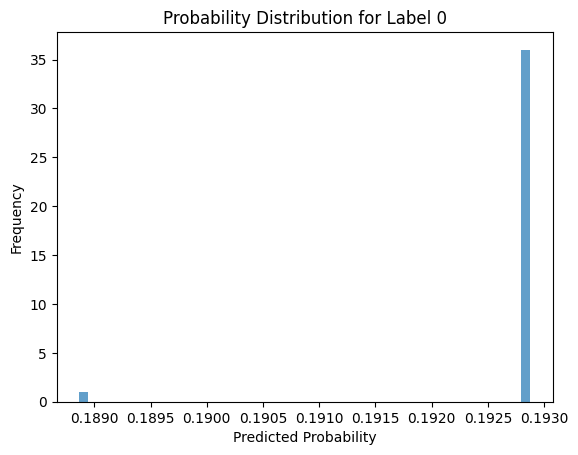

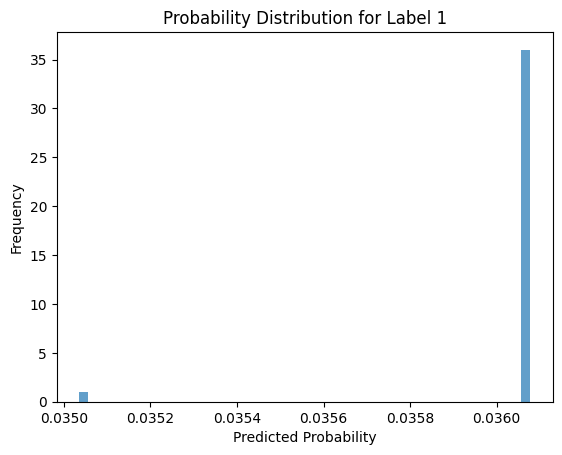

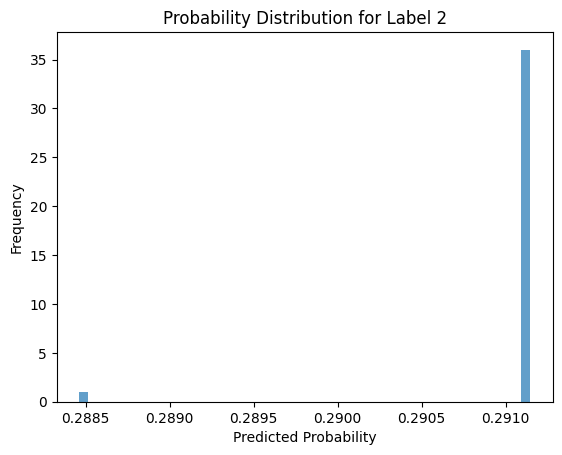

In [68]:
for i in range(probs.shape[1]):
    plt.hist(probs[:, i], bins=50, alpha=0.7)
    plt.title(f"Probability Distribution for Label {i}")
    plt.xlabel("Predicted Probability")
    plt.ylabel("Frequency")
    plt.show()

In [69]:
print("X_tensor stats:", X_tensor.min(), X_tensor.max(), X_tensor.mean())

X_tensor stats: tensor(-0.3162) tensor(164.1806) tensor(6.8046e-10)


In [70]:
best_thresholds, _ = tune_thresholds(y_true, probs, 'f1')

Label 0: Best threshold = 0.19, Best f1 = 0.4348
Label 1: Best threshold = 0.00, Best f1 = 0.1026
Label 2: Best threshold = 0.29, Best f1 = 0.5306


In [71]:
evaluate_multilabel_classification(
    y_true=y_true.numpy(),       # ground truth (0 or 1)
    y_pred=probs.numpy(),        # predicted probabilities
    label_names=label_names,
    threshold=best_thresholds               # you can try 0.4 or 0.6 too
)

({'micro_precision': 0.22935779816513763,
  'micro_recall': 1.0,
  'micro_f1': 0.373134328358209,
  'macro_precision': 0.230980980980981,
  'macro_recall': 1.0,
  'macro_f1': 0.35598631871923797,
  'weighted_precision': 0.3032132132132132,
  'weighted_recall': 1.0,
  'weighted_f1': 0.4580365390303278,
  'subset_accuracy': 0.0},
               precision    recall  f1-score  support
 Mint           0.277778  1.000000  0.434783     10.0
 Leak           0.054054  1.000000  0.102564      2.0
 Limit          0.361111  1.000000  0.530612     13.0
 micro avg      0.229358  1.000000  0.373134     25.0
 macro avg      0.230981  1.000000  0.355986     25.0
 weighted avg   0.303213  1.000000  0.458037     25.0
 samples avg    0.225225  0.486486  0.300000     25.0)

### C. Graph GNN

In [72]:
class GCN(nn.Module):
    def __init__(self, in_channels, hidden, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden)
        self.conv2 = GCNConv(hidden, hidden)
        self.lin = nn.Linear(hidden, out_channels)
    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        x = global_mean_pool(x, batch)
        return self.lin(x)


#### Load Data

In [73]:
with open(os.path.join(PATH, "txn.pkl"), "rb") as f:
    txn_data = pickle.load(f)

with open(os.path.join(PATH, "cfg.pkl"), "rb") as f:
    cfg_data = pickle.load(f)

In [74]:
txn_dataset = []

for i, (address, txn_graph_data) in enumerate(txn_data.items()):
    # Check if the address exists in the ground truth DataFrame
    if address in ground.set_index('Address').index:
        feature = txn_graph.loc[address] # Use txn_graph features for txn_dataset
        data = from_networkx(txn_graph_data)
        data.x = torch.tensor(feature.values, dtype=torch.float32).repeat(data.num_nodes, 1) # Repeat features for each node
        data.y = torch.tensor(ground.set_index('Address').loc[address][["Mint", "Leak", "Limit"]].values, dtype=torch.float32).unsqueeze(0) # Add a batch dimension
        if i < 10:
            print(data)
        txn_dataset.append(data)

cfg_dataset = []

for i, (address, cfg_graph_data) in enumerate(txn_data.items()):
    # Check if the address exists in the ground truth DataFrame
    if address in ground.set_index('Address').index:
        feature = cfg_graph.loc[address] # Use txn_graph features for txn_dataset
        data = from_networkx(txn_graph_data)
        data.x = torch.tensor(feature.values, dtype=torch.float32).repeat(data.num_nodes, 1) # Repeat features for each node
        data.y = torch.tensor(ground.set_index('Address').loc[address][["Mint", "Leak", "Limit"]].values, dtype=torch.float32).unsqueeze(0) # Add a batch dimension
        if i < 10:
            print(data)
        cfg_dataset.append(data)

Data(edge_index=[2, 1], tx_hash=[1], label=[1], gas=[1], num_nodes=2, x=[2, 6], y=[1, 3])
Data(edge_index=[2, 13], tx_hash=[13], label=[13], gas=[13], num_nodes=14, x=[14, 6], y=[1, 3])
Data(edge_index=[2, 65], tx_hash=[65], label=[65], gas=[65], num_nodes=66, x=[66, 6], y=[1, 3])
Data(edge_index=[2, 56], tx_hash=[56], label=[56], gas=[56], num_nodes=57, x=[57, 6], y=[1, 3])
Data(edge_index=[2, 252], tx_hash=[252], label=[252], gas=[252], num_nodes=253, x=[253, 6], y=[1, 3])
Data(edge_index=[2, 2], tx_hash=[2], label=[2], gas=[2], num_nodes=3, x=[3, 6], y=[1, 3])
Data(edge_index=[2, 5869], tx_hash=[5869], label=[5869], gas=[5869], num_nodes=5870, x=[5870, 6], y=[1, 3])
Data(edge_index=[2, 944], tx_hash=[944], label=[944], gas=[944], num_nodes=945, x=[945, 6], y=[1, 3])
Data(edge_index=[2, 58], tx_hash=[58], label=[58], gas=[58], num_nodes=59, x=[59, 6], y=[1, 3])
Data(edge_index=[2, 2], tx_hash=[2], label=[2], gas=[2], num_nodes=3, x=[3, 6], y=[1, 3])
Data(edge_index=[2, 1], tx_hash=[1

In [75]:
from torch_geometric.loader import DataLoader

# Use either txn_dataset or cfg_dataset
txn_train_loader = DataLoader(txn_dataset, batch_size=16, shuffle=True)
cfg_train_loader = DataLoader(cfg_dataset, batch_size=16, shuffle=True)

In [76]:
txn_model = GCN(in_channels=feature.shape[0], hidden=64, out_channels=3)  # 3 = Mint, Leak, Limit
cfg_model = GCN(in_channels=feature.shape[0], hidden=64, out_channels=3)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.BCEWithLogitsLoss()  # For multi-label classification

#### Train & Dvaluation

In [77]:
# Update optimizer to optimize txn_model parameters
optimizer = torch.optim.Adam(txn_model.parameters(), lr=1e-3)

for epoch in range(20):
    txn_model.train()
    total_loss = 0
    for batch in txn_train_loader:
        optimizer.zero_grad()
        out = txn_model(batch)  # Use txn_model and pass the batch
        loss = loss_fn(out, batch.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")

Epoch 1, Loss: 155.9216
Epoch 2, Loss: 92.6041
Epoch 3, Loss: 50.0826
Epoch 4, Loss: 11.9217
Epoch 5, Loss: 12.6379
Epoch 6, Loss: 18.1213
Epoch 7, Loss: 14.8395
Epoch 8, Loss: 22.0826
Epoch 9, Loss: 17.4794
Epoch 10, Loss: 19.3986
Epoch 11, Loss: 13.3989
Epoch 12, Loss: 13.6301
Epoch 13, Loss: 27.2463
Epoch 14, Loss: 9.7377
Epoch 15, Loss: 7.6776
Epoch 16, Loss: 5.7214
Epoch 17, Loss: 3.7703
Epoch 18, Loss: 6.4050
Epoch 19, Loss: 4.6326
Epoch 20, Loss: 7.1017


In [78]:
# Update optimizer to optimize cfg_model parameters
optimizer = torch.optim.Adam(cfg_model.parameters(), lr=1e-3)

for epoch in range(20):
    cfg_model.train()
    total_loss = 0
    for batch in cfg_train_loader:
        optimizer.zero_grad()
        out = cfg_model(batch)  # shape: [batch_size, 3] - Use cfg_model
        loss = loss_fn(out, batch.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")

Epoch 1, Loss: 24.8204
Epoch 2, Loss: 13.9080
Epoch 3, Loss: 6.2912
Epoch 4, Loss: 5.5086
Epoch 5, Loss: 7.4539
Epoch 6, Loss: 3.9172
Epoch 7, Loss: 3.5641
Epoch 8, Loss: 5.5356
Epoch 9, Loss: 3.0679
Epoch 10, Loss: 4.0448
Epoch 11, Loss: 2.5643
Epoch 12, Loss: 2.0927
Epoch 13, Loss: 2.8669
Epoch 14, Loss: 2.3633
Epoch 15, Loss: 1.6787
Epoch 16, Loss: 1.3916
Epoch 17, Loss: 1.5299
Epoch 18, Loss: 1.5849
Epoch 19, Loss: 1.5414
Epoch 20, Loss: 1.8548


In [79]:
model.eval()
all_logits = []
all_labels = []

with torch.no_grad():
    for batch in txn_train_loader:
        logits = txn_model(batch)
        all_logits.append(logits)
        all_labels.append(batch.y)

# Stack predictions
logits = torch.cat(all_logits)
probs = torch.sigmoid(logits)  # Convert logits to probabilities
y_true = torch.cat(all_labels)


In [80]:
best_thresholds, _ = tune_thresholds(y_true, probs)

Label 0: Best threshold = 0.51, Best f1 = 0.5517
Label 1: Best threshold = 0.33, Best f1 = 0.4000
Label 2: Best threshold = 0.01, Best f1 = 0.5789


In [81]:
evaluate_multilabel_classification(y_true.numpy(), probs.numpy(), label_names=label_names, threshold=best_thresholds)


({'micro_precision': 0.40384615384615385,
  'micro_recall': 0.84,
  'micro_f1': 0.5454545454545454,
  'macro_precision': 0.37035087719298243,
  'macro_recall': 0.882051282051282,
  'macro_f1': 0.5102238354506957,
  'weighted_precision': 0.41722105263157894,
  'weighted_recall': 0.84,
  'weighted_f1': 0.5537422867513613,
  'subset_accuracy': 0.2702702702702703},
               precision    recall  f1-score  support
 Mint           0.421053  0.800000  0.551724     10.0
 Leak           0.250000  1.000000  0.400000      2.0
 Limit          0.440000  0.846154  0.578947     13.0
 micro avg      0.403846  0.840000  0.545455     25.0
 macro avg      0.370351  0.882051  0.510224     25.0
 weighted avg   0.417221  0.840000  0.553742     25.0
 samples avg    0.364865  0.405405  0.369369     25.0)

In [82]:
model.eval()
all_logits = []
all_labels = []

with torch.no_grad():
    for batch in cfg_train_loader:
        logits = cfg_model(batch)
        all_logits.append(logits)
        all_labels.append(batch.y)

# Stack predictions
logits = torch.cat(all_logits)
probs = torch.sigmoid(logits)  # Convert logits to probabilities
y_true = torch.cat(all_labels)


In [83]:
best_thresholds, _ = tune_thresholds(y_true, probs)

Label 0: Best threshold = 0.37, Best f1 = 0.6364
Label 1: Best threshold = 0.00, Best f1 = 0.1026
Label 2: Best threshold = 0.12, Best f1 = 0.5854


In [84]:
evaluate_multilabel_classification(y_true.numpy(), probs.numpy(), label_names=label_names, threshold=best_thresholds)


({'micro_precision': 0.2727272727272727,
  'micro_recall': 0.84,
  'micro_f1': 0.4117647058823529,
  'macro_precision': 0.3553196053196053,
  'macro_recall': 0.8743589743589744,
  'macro_f1': 0.44143119752875853,
  'weighted_precision': 0.46051480051480054,
  'weighted_recall': 0.84,
  'weighted_f1': 0.5671408266530217,
  'subset_accuracy': 0.05405405405405406},
               precision    recall  f1-score  support
 Mint           0.583333  0.700000  0.636364     10.0
 Leak           0.054054  1.000000  0.102564      2.0
 Limit          0.428571  0.923077  0.585366     13.0
 micro avg      0.272727  0.840000  0.411765     25.0
 macro avg      0.355320  0.874359  0.441431     25.0
 weighted avg   0.460515  0.840000  0.567141     25.0
 samples avg    0.247748  0.391892  0.297297     25.0)